# BooksNN - Explore Correlations in Data

* Stationarity
* Lag-k scatter plot
* Autocorrelation
* Correlations between time series

## Load and preprocess data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyisbn #module for converting ISBN-13 to ISBN-10 and vice versa
import booksnn as bnn
from sklearn.preprocessing import StandardScaler

In [11]:
startdate = '2016-01-01'
enddate = '2020-05-10'

(up,uc,sr) = bnn.load_preprocess_data(100,startdate,enddate)

Num entries discarded: 39
Num entries discarded: 22
Num entries discarded: 20


## Look at one Series: Used Price 

### Plot Series and First Difference of Series
Going to use the first difference of the mean trend of all time series for prelim analysis. 

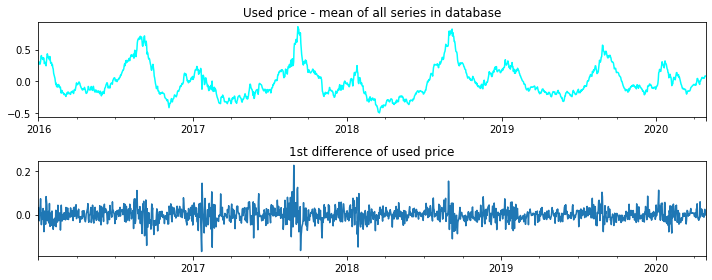

In [217]:
fig = plt.figure(figsize=(10,4))
plt.subplot(2, 1, 1)
up.mean(axis=1).plot(color='cyan')
plt.title('Used price - mean of all series in database')
plt.subplot(2, 1, 2)
series = up.mean(axis=1).diff().dropna()
series.plot()
plt.title('1st difference of used price')
plt.tight_layout()

### Test stationarity

A stationary series is de-trended and de-seasoned. It should have constant mean and constant variance throughout. 

Use Augmented Dickey-Fuller test to test for stationarity. 

In [198]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print('Series is Stationary \n\n')
    else:
        print('Series is Non-stationary \n\n')


#apply adf test on the series
print('First difference data: \n')
adf_test(series)

print('Original data: \n')
adf_test(up.mean(axis=1))

First difference data: 

Test Statistic         -1.137057e+01
p-value                 9.000518e-21
# Lags                  7.000000e+00
# Observations          1.571000e+03
Critical Value (1%)    -3.434519e+00
Critical Value (5%)    -2.863382e+00
Critical Value (10%)   -2.567750e+00
dtype: float64
Series is Stationary 


Original data: 

Test Statistic            -4.013747
p-value                    0.001340
# Lags                     8.000000
# Observations          1571.000000
Critical Value (1%)       -3.434519
Critical Value (5%)       -2.863382
Critical Value (10%)      -2.567750
dtype: float64
Series is Stationary 




The DF test says that both the original data and the first difference data series are stationary. The original series being stationary doesn't quite make sense. 

### Lag-k scatter plot

#### Used price series

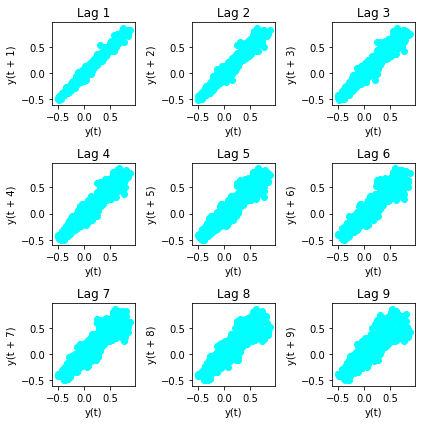

In [43]:
fig = plt.figure(figsize=(6,6))
for i in range(1,10):
    plt.subplot(3, 3, i)
    pd.plotting.lag_plot(up.mean(axis=1), lag=i, c='cyan')
    plt.title('Lag '+str(i))
    plt.gca().set_aspect("equal")
plt.tight_layout()

#### First difference of used price series

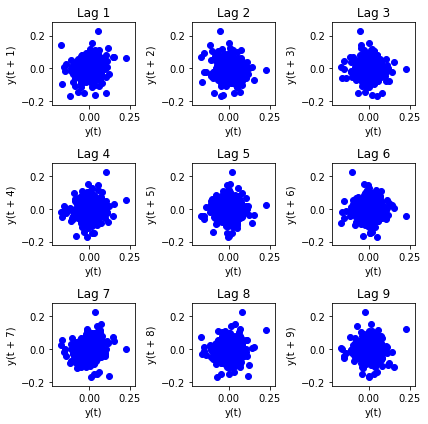

In [38]:
fig = plt.figure(figsize=(6,6))
for i in range(1,10):
    plt.subplot(3, 3, i)
    pd.plotting.lag_plot(series, lag=i, c='blue')
    plt.title('Lag '+str(i))
    plt.gca().set_aspect("equal")
plt.tight_layout()

The first difference series has much less autocorrelation - the scatter plots look blobby and not oblong. 

### Autocorrelation and partial autocorrelation
#### Used price data

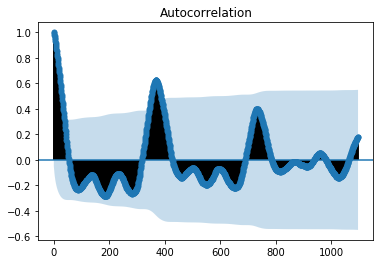

In [218]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(up.mean(axis=1), lags=365*3)

Note this is 3 years! The only strong correlations are a year back! 

#### First difference data
Full year and zoomed in

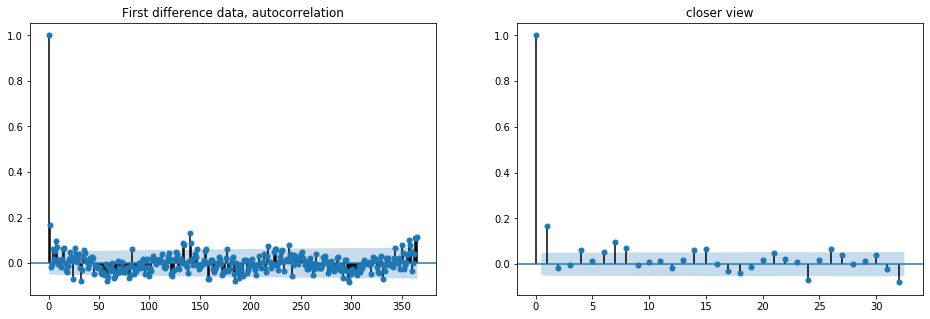

In [34]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
acf = plot_acf(series, lags=365,ax=ax1,title='First difference data, autocorrelation')
ax2 = fig.add_subplot(122)
acf = plot_acf(series,ax=ax2,title='closer view')

There is some evidence for weekly correlation, as well as around 130 days, and yearly. Overall there's too much going on for this to be very useful.

Now partial autocorrelations:

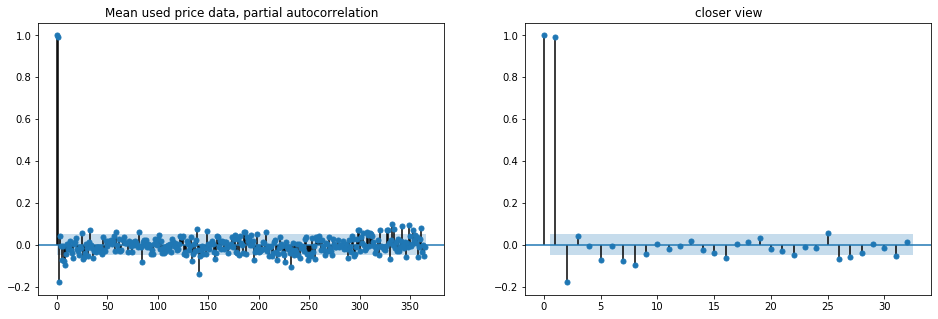

In [46]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
pacf = plot_pacf(up.mean(axis=1),lags=365,ax=ax1,title='Mean used price data, partial autocorrelation')
ax2 = fig.add_subplot(122)
pacf = plot_pacf(up.mean(axis=1),ax=ax2,title='closer view')

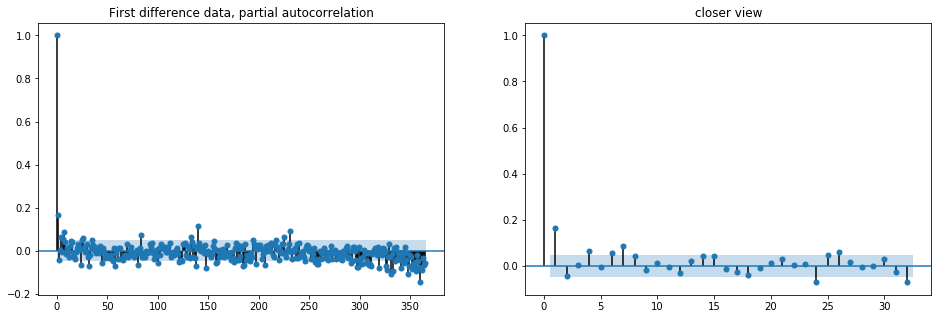

In [47]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
pacf = plot_pacf(series,lags=365,ax=ax1,title='First difference data, partial autocorrelation')
ax2 = fig.add_subplot(122)
pacf = plot_pacf(series,ax=ax2,title='closer view')

Same thing again, this time on monthly data. Simpler dataset will show more lower-order features in (P)ACF plots.

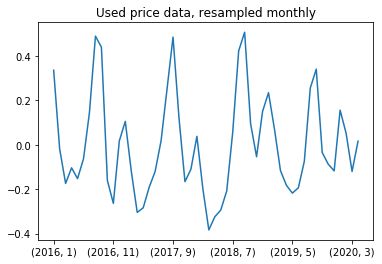

In [211]:
up_monthly = up.groupby([(up.index.year),(up.index.month)]).mean().mean(axis=1)
up_monthly.plot(title='Used price data, resampled monthly')

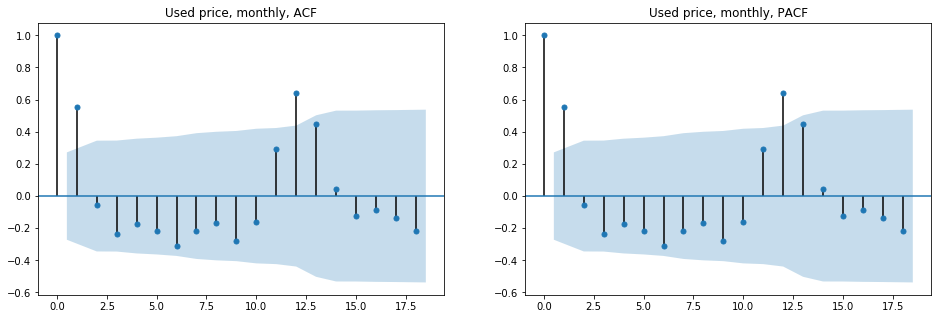

In [210]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
acf = plot_acf(up_monthly,ax=ax1,title='Used price, monthly, ACF')
ax2 = fig.add_subplot(122)
aacf = plot_acf(up_monthly,ax=ax2,title='Used price, monthly, PACF')

Ahh that's much nicer to look at. Makes a lot of sense - months 1,2, and 12 are strongly correlated. 

## Correlations between data series
* Pearson correlation
* Granger causality test
* Time-lagged cross-correlation

### Preprocessing mutlivariate series
Combine three series into single dataframe.

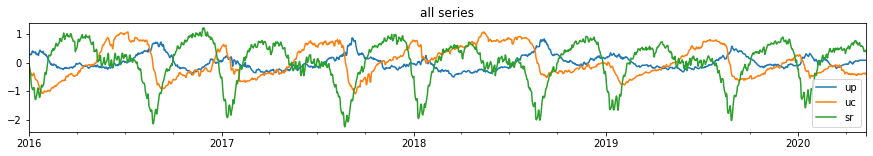

In [225]:
# First we need to combine data series into single dataframe. 
df_mean = pd.DataFrame((up.mean(axis=1),uc.mean(axis=1),sr.mean(axis=1))).T
df_mean = df_mean.fillna(method='ffill') #not sure why there are NaNs in the first place...

df_mean = df_mean.rename(columns={0: "up", 1: "uc",2:"sr"})

df_mean.plot(figsize=(15,2),title=('all series'))

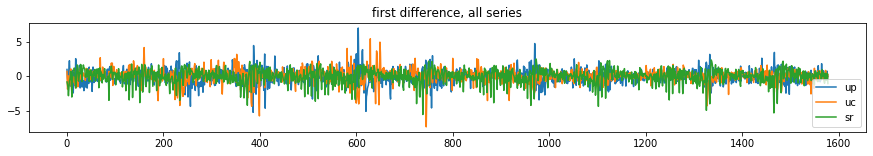

In [227]:
#Save first difference series
up_mean_fd = up.mean(axis=1).diff().dropna().to_numpy().reshape(1,-1)
uc_mean_fd = uc.mean(axis=1).diff().dropna().to_numpy().reshape(1,-1)
sr_mean_fd = sr.mean(axis=1).diff().dropna().to_numpy().reshape(1,-1)

#rescale each first difference series
up_mean_fd = StandardScaler().fit_transform(up_mean_fd.T)
uc_mean_fd = StandardScaler().fit_transform(uc_mean_fd.T)
sr_mean_fd = StandardScaler().fit_transform(sr_mean_fd.T)

up_mean_fd = up_mean_fd[0:1579]
uc_mean_fd = uc_mean_fd[0:1579]
sr_mean_fd = sr_mean_fd[0:1579]

# Create a single dataframe
# Some series are a little shorter - why? Due to NaNs?
df_mean_fd = pd.DataFrame(np.concatenate((up_mean_fd,uc_mean_fd,sr_mean_fd),axis=1))

df_mean_fd = df_mean_fd.rename(columns={0: "up", 1: "uc",2:"sr"})


#Plot all series
df_mean_fd.plot(figsize=(15,2),title=('first difference, all series'))



### Overall Pearson correlation
Not super useful by itself, but worth a glance. 

#### Used prices series:

In [174]:
df_mean.corr()

,0,1,2
0,1.000000,-0.259152,-0.693018
1,-0.259152,1.000000,-0.075705
2,-0.693018,-0.075705,1.000000


Interesting that used price and salesrank are strongly (negatively) correlated. Low salesrank means popular book which means high price - makes sense! 

#### First difference series:

In [175]:
df_mean_fd.corr()

,0,1,2
0,1.000000,-0.226034,-0.195091
1,-0.226034,1.000000,0.182777
2,-0.195091,0.182777,1.000000


### Sliding window correlation test

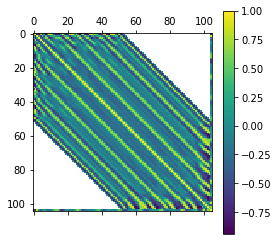

In [278]:
window_size = 30 #days
df_shifted = pd.DataFrame([up.mean(axis=1).shift(window_size*i) for i in range(-int(len(up)/window_size),int(len(up)/window_size))])
df_shifted = df_shifted.append(uc.mean(axis=1),ignore_index=True)

plt.matshow(df_shifted.T.corr())
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Time-lagged cross-correlation')

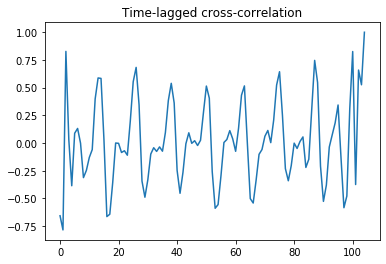

In [279]:
plt.plot(df_shifted.T.corr().to_numpy()[-1,:])
plt.title('Time-lagged cross-correlation')

In [ ]:
# Next need to fix the y axis to be centered about 0.

### Granger causality test
This test fits an AR model with one series, and then with two series. If the prediction is better with 2 series, then it assumes the series are correlated (Brian has a quip with "causality").

Useful: https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

#### Used price series:

In [213]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = grangercausalitytests(df_mean[df_mean.columns[0:2]], maxlag=1, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.0499 , p=0.0000  , df_denom=1587, df_num=1
ssr based chi2 test:   chi2=38.1218 , p=0.0000  , df=1
likelihood ratio test: chi2=37.6720 , p=0.0000  , df=1
parameter F test:         F=38.0499 , p=0.0000  , df_denom=1587, df_num=1


{1: ({'ssr_ftest': (38.049891271271356, 8.73315633173086e-10, 1587.0, 1),
   'ssr_chi2test': (38.121819232086615, 6.646273977665779e-10, 1),
   'lrtest': (37.671990978178655, 8.369775720390924e-10, 1),
   'params_ftest': (38.04989127127196, 8.733156331729309e-10, 1587.0, 1.0)},
   array([[0., 1., 0.]])])}

#### First difference series

In [216]:
granger_test = grangercausalitytests(df_mean_fd[df_mean_fd.columns[0:2]], maxlag=1, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4661 , p=0.0007  , df_denom=1575, df_num=1
ssr based chi2 test:   chi2=11.4880 , p=0.0007  , df=1
likelihood ratio test: chi2=11.4464 , p=0.0007  , df=1
parameter F test:         F=11.4661 , p=0.0007  , df_denom=1575, df_num=1


{1: ({'ssr_ftest': (11.466127129139648, 0.0007261987524515373, 1575.0, 1),
   'ssr_chi2test': (11.48796737129039, 0.0007004820116545374, 1),
   'lrtest': (11.446352557167302, 0.0007163447193442548, 1),
   'params_ftest': (11.466127129139453, 0.0007261987524515883, 1575.0, 1.0)},
   array([[0., 1., 0.]])])}

#### Cross-correlation Function

In [168]:
# Cross-corelation function
from statsmodels.tsa.stattools import ccf 

ccf_plot = ccf(up_mean_fd, uc_mean_fd)

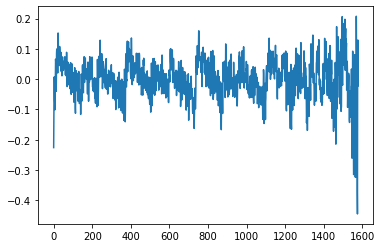

In [173]:
lt.plot(ccf_plot)